### 417 Final Project Codes -- Yue Huang; Jason Yang; Simon Zhu.

#### Part 1. Dataset Visualization

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = "D:/winequality-red.csv" #change this path according to your local address
dataset = pd.read_csv(
    dataset_path,
    sep=";",
)
dataset.columns = dataset.columns.str.replace('"', '') #remove the redundant quotes

Features of the dataset: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Number of datapoints: 1599
Shape: (1599, 12)


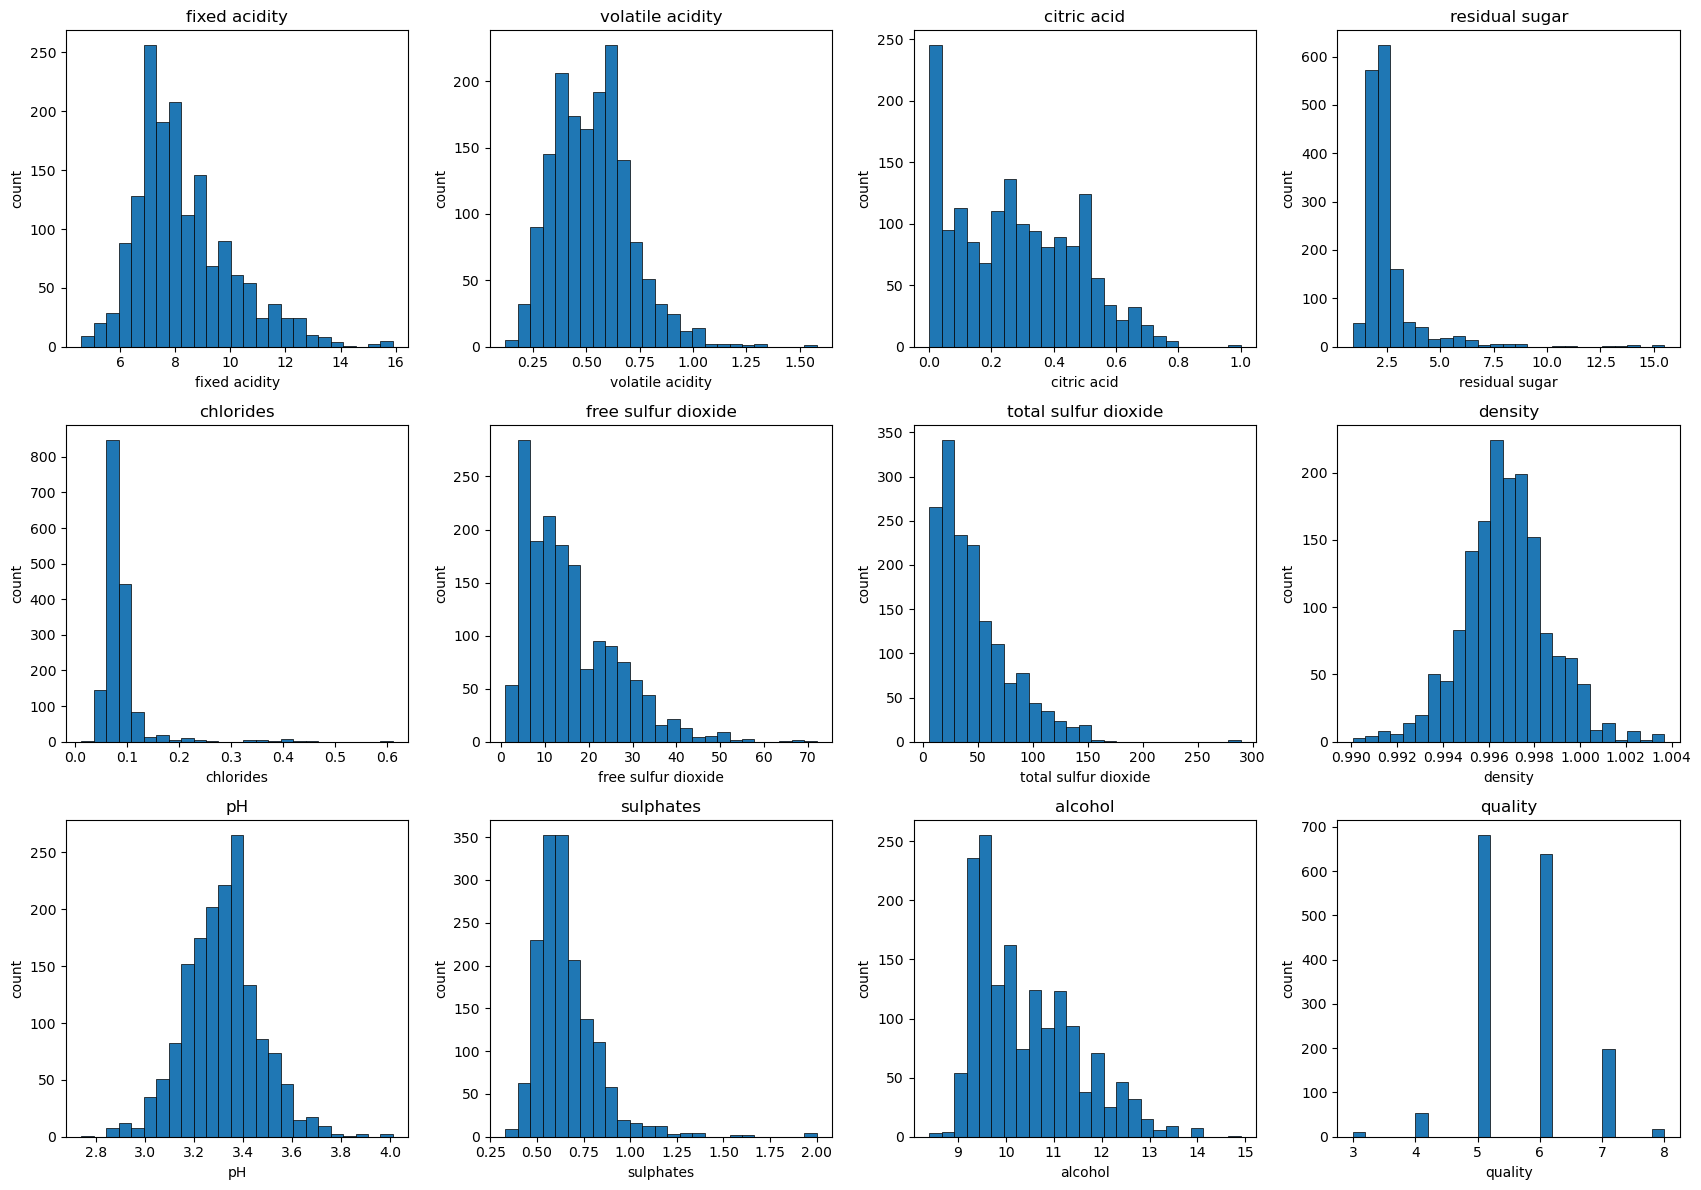

In [78]:
X = dataset.drop(columns=["quality"])
y = dataset["quality"]

print(f"Features of the dataset: {dataset.columns.tolist()}")
print(f"Number of datapoints: {len(dataset)}")
print(f"Shape: {dataset.shape}")

features = dataset.columns.tolist()
fig, plots = plt.subplots(3, 4, figsize=(17, 12))
plots = plots.flatten()
for i, column in enumerate(features):
    plots[i].hist(dataset[column], bins=25, edgecolor="black", linewidth=0.5)
    plots[i].set_title(column)
    plots[i].set_xlabel(column)
    plots[i].set_ylabel("count")
plt.tight_layout()
plt.show()


PCA explained variance ratio: [0.28173931 0.1750827 ]


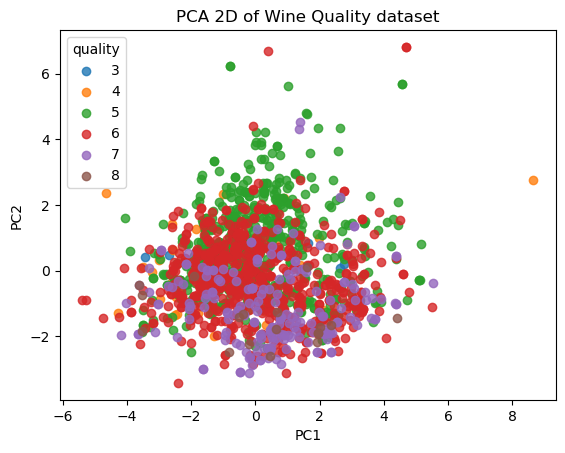

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit_transform(X_scaled)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

plt.figure()
qualities = np.sort(y.unique())
for quality in qualities:
    plt.scatter(
        X_r[y == quality, 0],
        X_r[y == quality, 1],
        alpha=0.8,
        label=str(quality)
    )
plt.legend(loc="best", shadow=False, scatterpoints=1, title="quality")
plt.title("PCA 2D of Wine Quality dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### Part 2. Classification

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y     #stratified sampling for train/test is necessary as datapoints of some quality scores are rare
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### Part 2.1 SVM Model

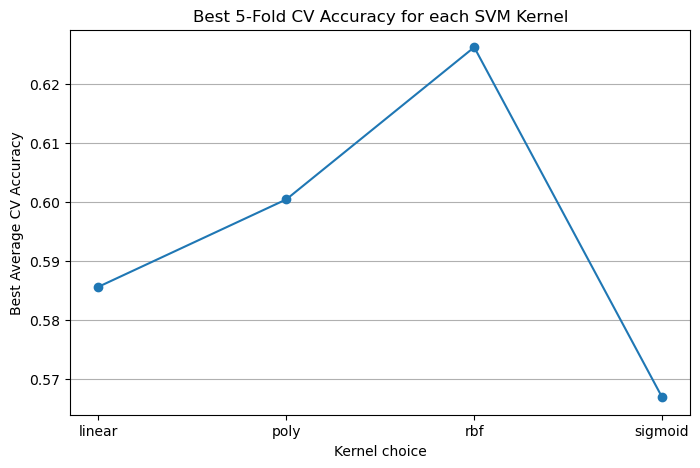

Best overall: kernel=rbf, C=5, mean 5-fold CV accuracy=0.6263


In [ ]:
#K-fold validation + hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

kf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

kernels = ["linear", "poly", "rbf", "sigmoid"]
C_list = [0.1, 1, 5, 10, 50]

best_by_kernel = {}  # Stores the best pair (best_C, best_score) for each kernel
best_kernel_overall = None  # Store the best kernel found overall
best_C_overall = None  # Store the best C value found overall
best_score_overall = -1  # Store the current best score overall

for ker in kernels:
    best_score_ker = -1 
    best_C_ker = None

    for C in C_list: #To find the best c_value (with the highest mean accuracy score)
        model = SVC(kernel=ker, C=C)
        scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, n_jobs=-1)
        mean_score = scores.mean()
        if mean_score > best_score_ker:
            best_score_ker = mean_score
            best_C_ker = C
    best_by_kernel[ker] = (best_C_ker, best_score_ker)

    if best_score_ker > best_score_overall: #check if the best score of this kernal is the highest score of all kernals' best
        best_kernel_overall = ker
        best_C_overall = best_C_ker
        best_score_overall = best_score_ker

# To graph the cross validation results (each kernal with its best score)
kernel_names = list(best_by_kernel.keys())
best_scores = []
for ker in kernel_names:
    best_scores.append(best_by_kernel[ker][1])

plt.figure(figsize=(8, 5))
plt.plot(kernel_names, best_scores, marker = 'o')
plt.title("Best 8-Fold CV Accuracy for each SVM Kernel")
plt.xlabel("Kernel choice")
plt.ylabel("Best Average CV Accuracy")
plt.grid(True, axis="y")
plt.show()

# This is the final choice: best kernel with the corresponding best C_value
print(f"Best overall: kernel={best_kernel_overall}, C={best_C_overall}, mean 8-fold CV accuracy={best_score_overall:.4f}")  



Our Choice of the SVM model hyperparameters: RBF kernal with C=5

Training accuracy (RBF, C=10): 0.7482
Test accuracy (RBF, C=10): 0.6250
Mean Absolute Error: 0.3969
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.66      0.72      0.69       136
           6       0.59      0.64      0.62       128
           7       0.69      0.50      0.58        40
           8       0.00      0.00      0.00         3

    accuracy                           0.62       320
   macro avg       0.32      0.31      0.31       320
weighted avg       0.61      0.62      0.61       320



d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


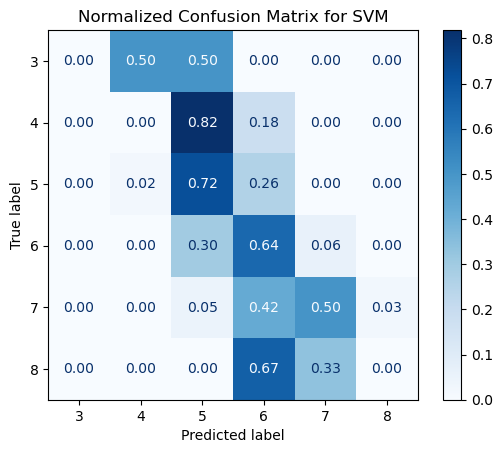

In [ ]:
#Train the SVM model with the best choice + training accuracy + test accuracy + confusion matrix heatmap
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

model = SVC(kernel="rbf", C=5)
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy (RBF, C=10): {train_acc:.4f}")
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (RBF, C=10): {test_acc:.4f}")

mae_svm = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error: {mae_svm:.4f}")  #mean absolute error

cm_norm = confusion_matrix(y_test, y_test_pred, normalize="true")
disp = ConfusionMatrixDisplay(cm_norm, display_labels=np.sort(y_train.unique()))
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix for SVM")
plt.show()